In [81]:
import polars as pl
from scipy.stats import spearmanr

In [89]:
preds = pl.read_parquet("../1_snakemake/outputs/cpcnn/mad_featselect/classifier_results/motive_binary_predictions.parquet")

In [90]:
preds_nodir = preds.filter(
    pl.col("Metadata_Label").str.contains("unknown_direction")
)

num_targets = (
    preds_nodir
    .filter(pl.col("y_actual") == 1)
    .group_by(["Metadata_OASIS_ID", "Metadata_AggType"])
    .agg(pl.count("y_actual").alias("Actual_target_count"))
)

num_pred_targets = (
    preds_nodir
    .filter(pl.col("y_pred") == 1)
    .group_by(["Metadata_OASIS_ID", "Metadata_AggType"])
    .agg(pl.count("y_actual").alias("Pred_target_count"))
)

preds_nodir = preds_nodir.join(num_targets, on=["Metadata_OASIS_ID", "Metadata_AggType"])
preds_nodir = preds_nodir.join(num_pred_targets, on=["Metadata_OASIS_ID", "Metadata_AggType"])

preds_nodir = preds_nodir.with_columns(
    (pl.col("y_actual")/pl.col("Actual_target_count")).alias("Actual_signal_strength"),
    (pl.col("y_pred")/pl.col("Pred_target_count")).alias("Pred_signal_strength"),
)

In [91]:
result = []
for agg_type, group in preds_nodir.group_by("Metadata_AggType"):
    sp_corr, sp_p = spearmanr(group["Actual_signal_strength"].to_list(), group["Pred_signal_strength"].to_list())

    result.append({"Metadata_AggType": agg_type, 
                   "spearman_corr": sp_corr, "spearman_pval": sp_p
                   })

result_df = pl.DataFrame(result)
print(result_df)

shape: (5, 3)
┌──────────────────┬───────────────┬───────────────┐
│ Metadata_AggType ┆ spearman_corr ┆ spearman_pval │
│ ---              ┆ ---           ┆ ---           │
│ list[str]        ┆ f64           ┆ f64           │
╞══════════════════╪═══════════════╪═══════════════╡
│ ["lastpodcc"]    ┆ 0.063896      ┆ 2.0232e-169   │
│ ["allpodcc"]     ┆ 0.054553      ┆ 1.8353e-126   │
│ ["allpod"]       ┆ 0.087709      ┆ 0.0           │
│ ["firstpod"]     ┆ 0.044997      ┆ 1.2099e-111   │
│ ["all"]          ┆ 0.024991      ┆ 1.2368e-210   │
└──────────────────┴───────────────┴───────────────┘


Note: for both Dino and CPCNN, "all" is the worst. For Dino, allpodcc was best while for CPCNN, allpod was the best. 

(2784477, 12)
(71566, 12)


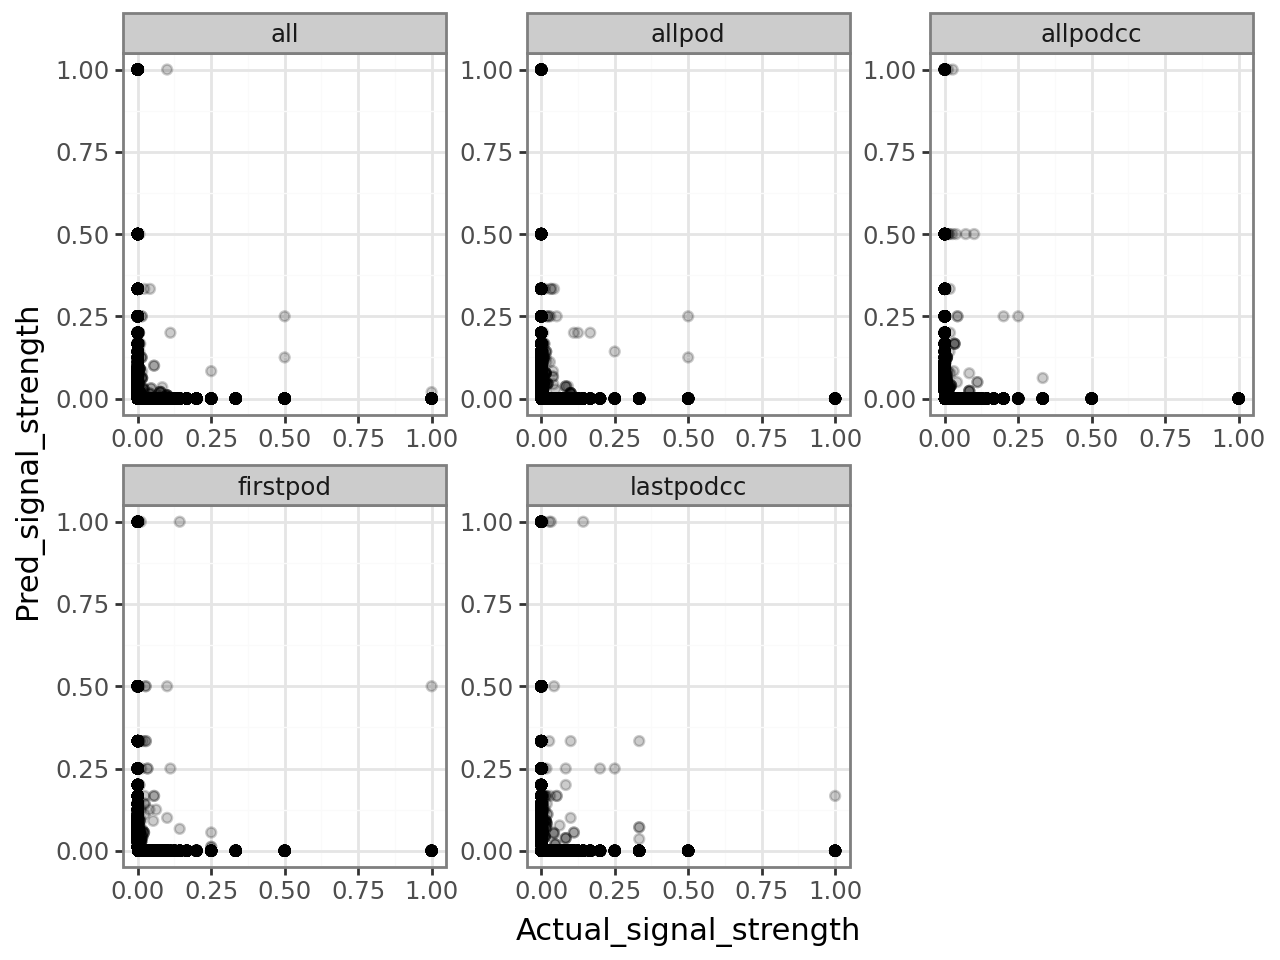

In [86]:
from plotnine import ggplot, aes, theme_bw, labs, geom_histogram, facet_wrap, geom_point

print(preds_nodir.shape)
preds_nodir_plot = preds_nodir.filter(
    ~((pl.col("Actual_signal_strength") == 0) & (pl.col("Pred_signal_strength") == 0))
)
print(preds_nodir_plot.shape)

plot = (
    ggplot(preds_nodir_plot, aes(x='Actual_signal_strength', y="Pred_signal_strength")) +
    geom_point(alpha=0.2) +
    facet_wrap("Metadata_AggType", scales="free") +
    theme_bw()
)
plot.show()